# Read in the data

In [16]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

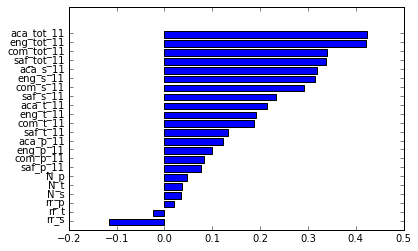

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
corr_survey = pd.DataFrame(correlations[survey_fields]).sort_values('sat_score', ascending=True)
bar_heights = corr_survey['sat_score']
bar_positions = np.arange(len(survey_fields)) + 0.5
col_labels = survey_fields
tick_positions = range(1,23)

ax.barh(bar_positions, bar_heights, 0.75)
ax.set_yticks(tick_positions)
ax.set_yticklabels(col_labels)
plt.show()

In [58]:
#high number of respondents (both students and parents) 
#has high correlation with SAT score.
#engagement, academic expectations and safety and respect 
#also positively correlated

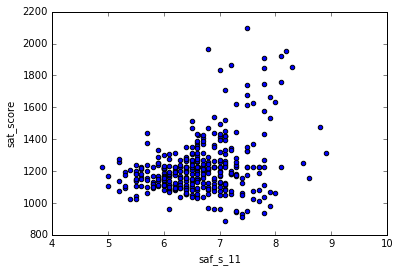

In [59]:
combined.plot.scatter(x='saf_s_11',y='sat_score')

In [60]:
#non-linear relationship between safety and SAT scores
#SAT scores only start increasing meaningfully if the safety
#score is at least 7

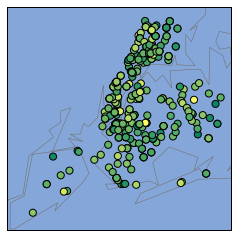

In [68]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection = 'merc',
    llcrnrlat = 40.496044,
    urcrnrlat = 40.915256,
    llcrnrlon = -74.255735,
    urcrnrlon = -73.700272,
    resolution = 'i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47',linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=combined['saf_s_11'], cmap='summer')

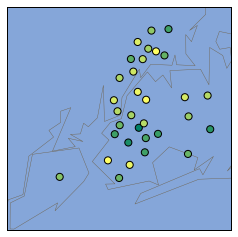

In [77]:
districts = combined.groupby('school_dist').agg(np.mean)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection = 'merc',
    llcrnrlat = 40.496044,
    urcrnrlat = 40.915256,
    llcrnrlon = -74.255735,
    urcrnrlon = -73.700272,
    resolution = 'i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47',linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')

In [78]:
#low safety scores in Brooklyn, Queens and Bronx

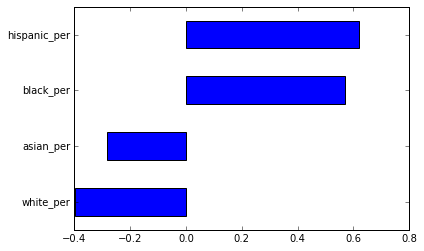

In [99]:
race_pct = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
fig, ax = plt.subplots()
corr_survey = pd.DataFrame(correlations[race_pct]).sort_values('sat_score', ascending=True)
bar_heights = corr_survey['sat_score']
bar_positions = np.arange(len(race_pct)) + 0.75
col_labels = race_pct
tick_positions = range(1,5)

ax.barh(bar_positions, bar_heights, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(col_labels)
plt.show()

In [85]:
#hispanic and black schools correlate positively with SAT scrore
#white schools have negative correlation

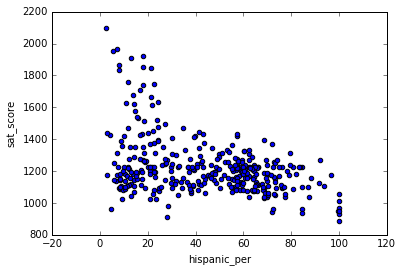

In [86]:
combined.plot.scatter(x='hispanic_per',y='sat_score')

In [87]:
#no real linear relationship btw hispanic % and SAT score

In [94]:
hisp_sch = combined['SCHOOL NAME'][combined['hispanic_per']>95]
hisp_sch

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [97]:
low_hisp_hi_sat = combined['SCHOOL NAME'][(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
low_hisp_hi_sat

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

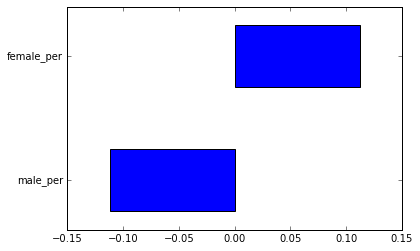

In [101]:
gen_pct = ['male_per', 'female_per']
fig, ax = plt.subplots()
corr_survey = pd.DataFrame(correlations[gen_pct]).sort_values('sat_score', ascending=True)
bar_heights = corr_survey['sat_score']
bar_positions = np.arange(len(gen_pct)) + 0.75
col_labels = gen_pct
tick_positions = range(1,3)

ax.barh(bar_positions, bar_heights, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(col_labels)
plt.show()

In [102]:
#high % female schools do better at SAT then high % male schools

In [103]:
hi_fem_hi_sat = combined['SCHOOL NAME'][(combined['female_per']>60) & (combined['sat_score']>1700)]
hi_fem_hi_sat

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

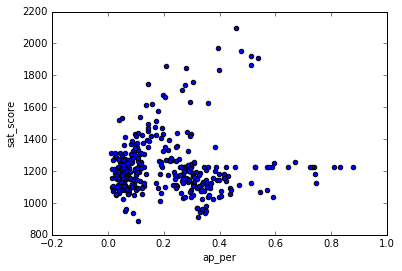

In [104]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per',y='sat_score')

In [105]:
#no real linear relationship between ap % and SAT score